In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.express as px
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

In [2]:
df = pd.read_csv('C:/Users/osegh/Desktop/UVA/ML 1 Intro to Predictive Modeling/ML-Healthdata-project/joining_data/CDC-2019-2021-2023-DATA.csv')

df.head()

C:\Users\osegh\AppData\Local\Temp\ipykernel_37872\3606275901.py:1: DtypeWarning: Columns (1,4,7,8,9,10,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:/Users/osegh/Desktop/UVA/ML 1 Intro to Predictive Modeling/ML-Healthdata-project/joining_data/CDC-2019-2021-2023-DATA.csv')


,Unnamed: 0,BIRTHSEX,MENTHLTH,POORHLTH,ADDEPEV3,DECIDE,DIFFALON,ACEDEPRS,ACEDRINK,ACEDRUGS,ACEPRISN,ACEDIVRC,ACEPUNCH,ACEHURT1,ACESWEAR,ACETOUCH,ACETTHEM,ACEHVSEX,IYEAR
0,0,NaN,0.0,0.0,No,No,No,No,No,No,No,Yes,Never,More than once,Never,Never,Never,Never,2019
1,1,NaN,0.0,10.0,No,No,No,No,Yes,No,No,No,Never,Once,More than once,Never,Never,Never,2019
2,2,NaN,30.0,0.0,No,No,No,No,No,No,No,No,NaN,Never,Never,Never,Never,Never,2019
3,3,NaN,0.0,0.0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019
4,4,NaN,0.0,NaN,No,No,No,No,No,No,No,No,Never,Never,Never,Never,Never,Never,2019


- MENTHLTH : Now thinking about your mental health, which includes stress, depression, and problems with emotions, for
how many days during the past 30 days was your mental health not good? 


- ADDEPEV3 : (Ever told) (you had) a depressive disorder (including depression, major depression, dysthymia, or minor
depression)? 

In [3]:
df.columns.unique()

Index(['Unnamed: 0', 'BIRTHSEX', 'MENTHLTH', 'POORHLTH', 'ADDEPEV3', 'DECIDE',
       'DIFFALON', 'ACEDEPRS', 'ACEDRINK', 'ACEDRUGS', 'ACEPRISN', 'ACEDIVRC',
       'ACEPUNCH', 'ACEHURT1', 'ACESWEAR', 'ACETOUCH', 'ACETTHEM', 'ACEHVSEX',
       'IYEAR'],
      dtype='object')

In [4]:
ace_YN = ['ACEDEPRS', 'ACEDRINK', 'ACEDRUGS', 'ACEPRISN', 'ACEDIVRC']
ace_NOM = ['ACEPUNCH', 'ACEHURT1', 'ACESWEAR', 'ACETOUCH', 'ACETTHEM', 'ACEHVSEX']
cat_cols = ace_YN + ace_NOM

In [5]:
mental_health_cols = ['MENTHLTH', 'POORHLTH', 'ADDEPEV3', 'DECIDE', 'DIFFALON']

In [6]:
df_clean = df.dropna(subset=cat_cols)

In [7]:
from gower import gower_matrix


decided to use gower python libary because the inital code I had was just counting mismatches, not properly handling ordinal variables like Never/Once/More than once.

In [10]:
df_sample = df_clean.sample(n=10000, random_state=42)

distance_matrix = gower_matrix(df_sample[cat_cols])
print("Distance matrix shape:", distance_matrix.shape)
print("Distance matrix type:", type(distance_matrix))

Distance matrix shape: (10000, 10000)
Distance matrix type: <class 'numpy.ndarray'>


In [ ]:
import sys
print(f"Current recursion limit: {sys.getrecursionlimit()}")
sys.setrecursionlimit(50000)

Current recursion limit: 3000


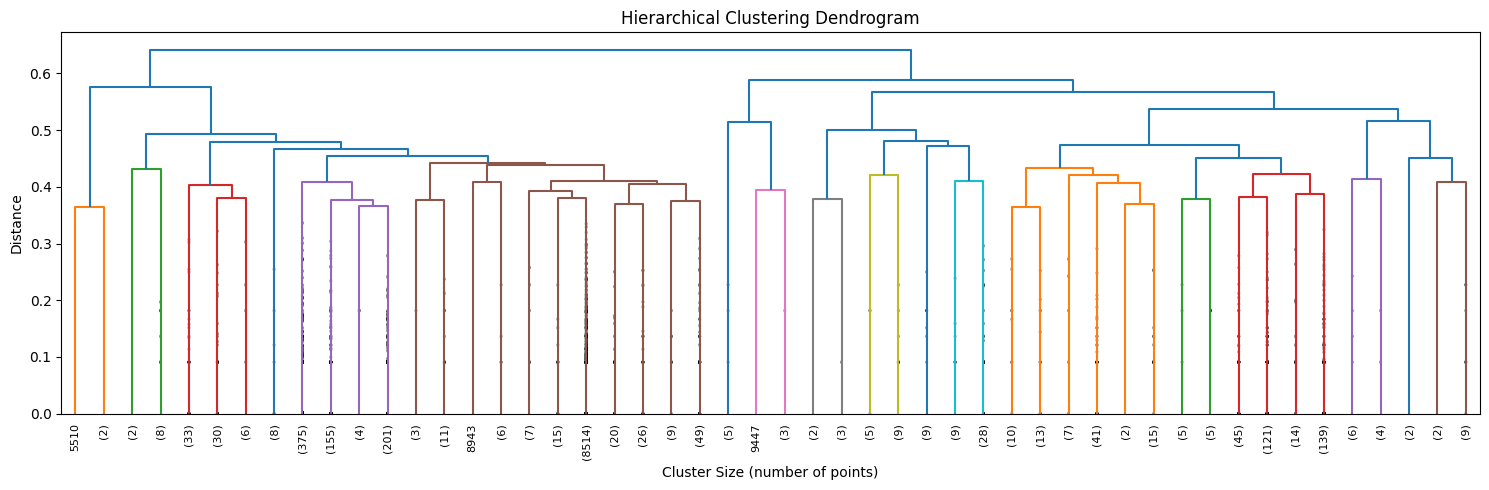

In [17]:
Z = linkage(squareform(distance_matrix, checks=False), method='average')

plt.figure(figsize=(15, 5))
dendrogram(Z,
    truncate_mode='lastp',  # Show only the last p merged clusters
    p=50,                   # Show top 50 branches
    show_leaf_counts=True,  # Show number of samples in each group
    show_contracted=True)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Cluster Size (number of points)")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

In [34]:
sil_results = []

for k in range(2, 5):
    model = AgglomerativeClustering(
    n_clusters=k,
    metric="precomputed",
    linkage='average' 
    )
    labels_k = model.fit_predict(distance_matrix)

    sil = silhouette_score(distance_matrix, labels_k, metric="precomputed")
    
    sil_results.append({"k": k, "silhouette": sil})

sil_df = pd.DataFrame(sil_results)
print("\nSilhouette scores:\n", sil_df)

best_k = sil_df.loc[sil_df["silhouette"].idxmax(), "k"]
print("Best K by silhouette (Gower):", int(best_k))


Silhouette scores:
    k  silhouette
0  2    0.629567
1  3    0.612130
2  4    0.578271
Best K by silhouette (Gower): 2


In [19]:
px.line(
    sil_df,
    x="k",
    y="silhouette", 
    markers=True,
    title="Silhouette Scores for Different K (Gower Distance)"
)

# Model with best k (n = 2) as cluster

In [35]:
final_model = AgglomerativeClustering(
n_clusters= best_k,
metric="precomputed",
linkage='average'
)
final_labels = final_model.fit_predict(distance_matrix)

In [36]:
df_sample["cluster"] = final_labels
print(f"\nFinal Clustering Results (k=2):")
print(df_sample["cluster"].value_counts().sort_index())


Final Clustering Results (k=2):
cluster
0     514
1    9486
Name: count, dtype: int64


### Crosstab clusters with Adverce childhood Experience 

In [38]:
for col in cat_cols:
        print(pd.crosstab(df_sample["cluster"], df_sample[col], normalize='index'))

ACEDEPRS        No       Yes
cluster                     
0         0.363813  0.636187
1         0.851465  0.148535
ACEDRINK        No       Yes
cluster                     
0         0.264591  0.735409
1         0.805081  0.194919
ACEDRUGS        No       Yes
cluster                     
0         0.548638  0.451362
1         0.930002  0.069998
ACEPRISN        No       Yes
cluster                     
0         0.647860  0.352140
1         0.951402  0.048598
ACEDIVRC        No  Parents not married       Yes
cluster                                          
0         0.406615             0.029183  0.564202
1         0.764600             0.013072  0.222328
ACEPUNCH  More than once     Never      Once
cluster                                     
0               0.540856  0.392996  0.066148
1               0.092979  0.870651  0.036369
ACEHURT1  More than once     Never      Once
cluster                                     
0               0.620623  0.307393  0.071984
1               0.140

Model: CT Cluster with ACE heatmap

In [66]:
heatmap_matrix = []
heatmap_labels = []

# Data Processing Loop
for col in cat_cols:
    if col in df_sample.columns:
        crosstab = pd.crosstab(df_sample["cluster"], df_sample[col], normalize='index')
        for category in crosstab.columns:
            heatmap_matrix.append([
                crosstab.loc[0, category] * 100,  # Cluster 0
                crosstab.loc[1, category] * 100   # Cluster 1
            ])
            heatmap_labels.append(f"<b>{col}</b><br>{category}")

heatmap_matrix = np.array(heatmap_matrix)

custom_colors = [
    [0.0, "#d1eeff"],  # Very Light Blue
    [0.33, "#6b8cce"], # Blue/Indigo
    [0.66, "#9b59b6"], # Purple/Violet
    [1.0, "#ff69b4"]   # Hot Pink
]

row_height = 35
dynamic_height = max(600, len(heatmap_labels) * row_height)

fig2 = go.Figure(data=go.Heatmap(
    z=heatmap_matrix,
    y=heatmap_labels,
    x=['High Risk / High ACE', 'Low Risk / Low ACE'],
    colorscale=custom_colors, 
    text=np.round(heatmap_matrix, 1),
    texttemplate='%{text}%',
    textfont={"size": 11}, 
    colorbar=dict(title="Percentage (%)"),
    xgap=2, 
    ygap=2  
))

fig2.update_layout(
    title='All ACE Variables: Proportion Heatmap by Cluster',
    xaxis_title='Cluster',
    yaxis_title='Variable & Category',
    height=dynamic_height, 
    yaxis=dict(
        dtick=1,
        automargin=True 
    )
)

fig2.show()

Model: CT Cluster with ACE drop down with toggle

In [60]:
color_c0 = '#6b8cce' 
color_c1 = '#ff69b4' 

fig3 = go.Figure()

buttons = []

for i, col in enumerate(cat_cols):
    crosstab = pd.crosstab(df_sample["cluster"], df_sample[col], normalize='index') * 100
    categories = crosstab.columns.tolist()
    
    is_visible = (i == 0)

    # Bar for Cluster 0
    fig3.add_trace(
        go.Bar(
            x=categories, 
            y=crosstab.loc[0], 
            name='High Risk / High ACE',
            marker_color=color_c0,
            visible=is_visible 
        )
    )

    # Bar for Cluster 1
    fig3.add_trace(
        go.Bar(
            x=categories, 
            y=crosstab.loc[1], 
            name='Low Risk / Low ACE',
            marker_color=color_c1,
            visible=is_visible
        )
    )

    # Dropdown 
    visible_settings = [False] * (len(cat_cols) * 2)
    
    visible_settings[2*i] = True     
    visible_settings[2*i + 1] = True

    buttons.append(dict(
        label=col,
        method="update",
        args=[
            {"visible": visible_settings}, 
            {"title": f"Comparison: {col} by Cluster"} 
        ]
    ))

fig3.update_layout(
    title=f"Comparison: {cat_cols[0]} by Cluster",
    yaxis_title="Percentage (%)",
    xaxis_title="Category",
    barmode='group',
    height=600, 
    margin=dict(r=200), 
    
    legend=dict(
        x=1.05,        
        y=1.0,        
        xanchor='left',
        yanchor='top'
    ),
    
    # Dropdown under the Legend
    updatemenus=[
        dict(
            buttons=buttons,
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=1.05,      
            xanchor="left",
            y=0.85,     
            yanchor="top"
        )
    ]
)

fig3.show()

In [42]:
df_sample['ADDEPEV3'] = df_sample['ADDEPEV3'].replace({
    0.0: 'No', 
    1.0: 'Yes', 
    0: 'No', 
    1: 'Yes'
})

# List of categorical columns
cat_mh_cols = ['ADDEPEV3', 'DECIDE', 'DIFFALON']

for col in cat_mh_cols:
    print(pd.crosstab(df_sample['cluster'], df_sample[col], normalize='index').round(2))

ADDEPEV3    No   Yes
cluster             
0         0.51  0.49
1         0.82  0.18
DECIDE     No   Yes
cluster            
0        0.67  0.33
1        0.90  0.10
DIFFALON    No   Yes
cluster             
0         0.78  0.22
1         0.93  0.07


In [ ]:
# List of columns
cat_mh_cols = ['ADDEPEV3', 'DECIDE', 'DIFFALON']
titles = ["Depressive Disorder", "Difficulty Deciding", "Difficulty Errands Alone"]

fig6 = make_subplots(
    rows=3, cols=1,
    subplot_titles=titles,
    vertical_spacing=0.1, 
    shared_xaxes=False 
)

c0_color = '#6b8cce'
c1_color = '#ff69b4'

for i, col in enumerate(cat_mh_cols):
    ct = pd.crosstab(df_sample['cluster'], df_sample[col], normalize='index') * 100
    labels = ct.columns.astype(str)

    # Cluster 0
    fig6.add_trace(go.Bar(
        x=labels, y=ct.loc[0],
        name='High Risk / High ACE',
        marker_color=c0_color,
        showlegend=(i==0) # Only show legend on the top graph
    ), row=i+1, col=1) 

    # Cluster 1
    fig6.add_trace(go.Bar(
        x=labels, y=ct.loc[1],
        name='Low Risk / Low ACE',
        marker_color=c1_color,
        showlegend=(i==0)
    ), row=i+1, col=1)

fig6.update_layout(
    title='Mental Health & Functional Difficulty',
    barmode='group',
    height=800,
    width=900,      
    bargap=0.4,     
    bargroupgap=0.1 
)

# Update Y-axis labels
fig6.update_yaxes(title_text="Percentage (%)", row=1, col=1)
fig6.update_yaxes(title_text="Percentage (%)", row=2, col=1)
fig6.update_yaxes(title_text="Percentage (%)", row=3, col=1)

fig6.show()

In [44]:
# List of numerical columns
num_mh_cols = ['MENTHLTH', 'POORHLTH']
print("Average Days of Poor Health by Cluster")
print(df_sample.groupby('cluster')[num_mh_cols].mean())

print(df_sample.groupby('cluster')['MENTHLTH'].describe())


Average Days of Poor Health by Cluster
          MENTHLTH  POORHLTH
cluster                     
0        10.834661  9.311164
1         3.545933  4.862865
          count       mean        std  min  25%  50%   75%   max
cluster                                                         
0         502.0  10.834661  11.888813  0.0  0.0  5.0  20.0  30.0
1        9318.0   3.545933   7.612685  0.0  0.0  0.0   3.0  30.0


In [ ]:
fig_violin = go.Figure()

# Define variables
metrics = ['MENTHLTH', 'POORHLTH']
x_labels = ['Mental Health', 'Physical Health'] 

for i, col in enumerate(metrics):
    show_legend = (i == 0)

    # Cluster 0 (Left Side / Blue) 
    fig_violin.add_trace(go.Violin(
        y=df_sample[df_sample['cluster'] == 0][col],
        x=[x_labels[i]] * len(df_sample[df_sample['cluster'] == 0]),
        legendgroup='High Risk / High ACE', 
        scalegroup='Cluster 0', 
        name='High Risk / High ACE',
        side='negative',
        line_color='#6b8cce',
        fillcolor='#6b8cce',
        opacity=0.6,
        meanline_visible=True,
        showlegend=show_legend,
        spanmode='hard'  # <--- PREVENTS VIOLIN FROM GOING BELOW 0
    ))

    # Cluster 1 (Right Side / Pink) 
    fig_violin.add_trace(go.Violin(
        y=df_sample[df_sample['cluster'] == 1][col],
        x=[x_labels[i]] * len(df_sample[df_sample['cluster'] == 1]), 
        legendgroup='Low Risk / Low ACE', 
        scalegroup='Cluster 1', 
        name='Low Risk / Low ACE',
        side='positive',
        line_color='#ff69b4',
        fillcolor='#ff69b4',
        opacity=0.6,
        meanline_visible=True,
        showlegend=show_legend,
        spanmode='hard' # <--- PREVENTS VIOLIN FROM GOING BELOW 0
    ))

# Reduced width from 0.8 to 0.5 to make them thinner
fig_violin.update_traces(width=0.5, points=False) 

fig_violin.update_layout(
    title='Distribution of Unhealthy Days (Split Violin)',
    xaxis_title='Health Metric',
    
    
    yaxis=dict(title='Days (0-30)', range=[0, 30]),
    
    violingap=0, 
    violingroupgap=0,
    violinmode='overlay',
    height=600,
    legend=dict(title="Cluster Group")
)

fig_violin.show()

# Summary (k=2 Clustering)

## Cluster Distribution

- **Cluster 0 (High ACE)**: 514 people (5.1%)
- **Cluster 1 (Low ACE)**: 9,486 people (94.9%)


### Cluster 1: Low ACE Exposure (94.9% - General Population)

#### Childhood Environment: Relatively Stable and Safe

**Household Dysfunction** - Minimal
- 85% no depressed household members
- 81% no alcoholic household members  
- 93% no drug-using household members
- 95% no incarcerated household members
- 76% parents stayed together

**Abuse/Violence** - Rare
- 87% never witnessed domestic violence
- 80% never physically hurt (beyond spanking)
- 72% never verbally abused
- 94% never sexually touched
- 96% never experienced attempted sexual assault
- 98% never forced into sex

#### Adult Mental Health: Good Functioning
- 82% never diagnosed with depression
- 90% no difficulty concentrating/deciding
- 93% no difficulty doing errands
- 3.5 days/month poor mental health
- 4.9 days/month activity limitation


### Cluster 0: High ACE Exposure (5.1% - High-Risk Group)

This group experienced *severe, pervasive trauma across nearly every category.

#### Household Dysfunction (Multiple Risk Factors)

| ACE Type | Prevalence | vs. Cluster 1 |
|----------|-----------|---------------|
| Depressed/mentally ill household member | 64% | 4.3x higher |
| Alcoholic household member | 74% | 3.8x higher |
| Drug-using household member | 45% | 6.4x higher |
| Incarcerated household member | 35% | 7.2x higher |
| Parental separation/divorce | 56% | 2.5x higher |

#### Direct Violence/Abuse (Chronic and Severe)

**Physical and Emotional Abuse:**
- 54% witnessed domestic violence more than once (vs. 9% in Cluster 1)
- 62% physically hurt more than once (vs. 14% in Cluster 1)  
- 80% verbally abused more than once (vs. 23% in Cluster 1)

**Sexual Abuse** (Most Striking Difference):
- 84% sexually touched more than once (vs. 3% in Cluster 1) — 28x higher
- 75% experienced attempted sexual assault more than once (vs. 1% in Cluster 1) — 54x higher
- 50% forced into sex more than once (vs. 0.6% in Cluster 1) — 78x higher

#### Adult Mental Health Outcomes (Severe Impairment)

| Outcome | Cluster 0 | Cluster 1 | Relative Risk |
|---------|-----------|-----------|---------------|
| Depression diagnosis | 49% | 18% | 2.7x |
| Difficulty concentrating/deciding | 33% | 10% | 3.3x |
| Difficulty doing errands alone | 22% | 7% | 3.1x |
| Poor mental health days/month | 10.8 | 3.5 | 3.1x |
| Activity limitation days/month | 9.3 | 4.9 | 1.9x |


# Model with k (n = 3) clusters

In [57]:
# Fit Model with k=3 and complete linkage
model_k3 = AgglomerativeClustering(
    n_clusters=3,
    metric="precomputed",
    linkage='average' 
)

labels_k3 = model_k3.fit_predict(distance_matrix)
df_sample['cluster_complete'] = labels_k3

print("Counts with Complete Linkage (k=3):")
print(df_sample['cluster_complete'].value_counts().sort_index())

Counts with Complete Linkage (k=3):
cluster_complete
0    9486
1     505
2       9
Name: count, dtype: int64


In [49]:
for col in cat_cols:
        print(pd.crosstab(df_sample["cluster_complete"], df_sample[col], normalize='index'))

ACEDEPRS                No       Yes
cluster_complete                    
0                 0.851465  0.148535
1                 0.358416  0.641584
2                 0.666667  0.333333
ACEDRINK                No       Yes
cluster_complete                    
0                 0.805081  0.194919
1                 0.253465  0.746535
2                 0.888889  0.111111
ACEDRUGS                No       Yes
cluster_complete                    
0                 0.930002  0.069998
1                 0.544554  0.455446
2                 0.777778  0.222222
ACEPRISN                No       Yes
cluster_complete                    
0                 0.951402  0.048598
1                 0.653465  0.346535
2                 0.333333  0.666667
ACEDIVRC                No  Parents not married       Yes
cluster_complete                                         
0                 0.764600             0.013072  0.222328
1                 0.407921             0.029703  0.562376
2                 0.333333  

In [55]:
cat_mh_cols = ['ADDEPEV3', 'DECIDE', 'DIFFALON']

for col in cat_mh_cols:
    print(pd.crosstab(df_sample['cluster_complete'], df_sample[col], normalize='index').round(2))

ADDEPEV3            No   Yes
cluster_complete            
0                 0.82  0.18
1                 0.51  0.49
2                 0.56  0.44
DECIDE              No   Yes
cluster_complete            
0                 0.90  0.10
1                 0.67  0.33
2                 0.67  0.33
DIFFALON            No   Yes
cluster_complete            
0                 0.93  0.07
1                 0.78  0.22
2                 0.78  0.22


In [56]:
# List of numerical columns
num_mh_cols = ['MENTHLTH', 'POORHLTH']
print("Average Days of Poor Health by Cluster")
print(df_sample.groupby('cluster_complete')[num_mh_cols].mean())


Average Days of Poor Health by Cluster
                   MENTHLTH  POORHLTH
cluster_complete                     
0                  3.545933  4.862865
1                 10.876268  9.363196
2                  8.555556  6.625000


## Summary 


Performed hierarchical clustering on a precomputed distance matrix with k=3 clusters using average linkage. The resulting clusters show a highly imbalanced distribution (9,486, 505, and 9 samples).

The analysis reveals three distinct groups based on Adverse Childhood Experiences (ACEs): Cluster 0 represents low ACE exposure with good mental health outcomes (3.5 poor mental health days), Cluster 1 shows high ACE exposure across all categories with significantly worse mental health (10.9 poor mental health days, 49% depression rate), and Cluster 2 is a small extreme group with the highest rates of severe abuse (89% physical violence, 56% sexual assault) but moderate mental health impacts, possibly due to small sample size (n=9) making it less reliable for interpretation.



### Why k=2 Works Better Than k=3
1. No micro-clusters: Eliminated the 9-person outlier group
2. Clear separation: Two distinct trauma exposure profiles
3. Statistical power: Both clusters have sufficient sample sizes (n=514 and n=9,486)

ACEDEPRS: Did you live with anyone who was depressed, mentally ill, or suicidal? 


ACEDRINK: Did you live with anyone who was a problem drinker or alcoholic? 


ACEDRUGS: Did you live with anyone who used illegal street drugs or who abused prescription medications? 


ACEPRISN: Did you live with anyone who served time or was sentenced to serve time in a prison, jail, or other correctional facility? 


ACEDIVRC: Were your parents separated or divorced? 


ACEPUNCH: How often did your parents or adults in your home ever slap, hit, kick, punch or beat each other up? 


ACEHURT1: Not including spanking, (before age 18), how often did a parent or adult in your home ever hit, beat, kick, or physically hurt you in any way? 


ACESWEAR: How often did a parent or adult in your home ever swear at you, insult you, or put you down? 


ACETOUCH: How often did anyone at least 5 years older than you or an adult, ever touch you sexually? 


ACETTHEM: How often did anyone at least 5 years older than you or an adult, try to make you touch them sexually? 


ACEHVSEX: How often did anyone at least 5 years older than you or an adult, force you to have sex?


ADDEPEV3: (Ever told) (you had) a depressive disorder (including depression, major depression, dysthymia, or minor depression)? 


DECIDE: Because of a physical, mental, or emotional condition, do you have serious difficulty concentrating, remembering, or making decisions? 


DIFFALON: Because of a physical, mental, or emotional condition, do you have difficulty doing errands alone such as visiting a doctor's office or shopping?

MENTHLTH: Now thinking about your mental health, which includes stress, depression, and problems with emotions, for how many days during the past 30 days was your mental health not good? 


POORHLTH: During the past 30 days, for about how many days did poor physical or mental health keep you from doing your usual activities, such as self-care, work, or recreation?